# Fractional Differentiation of Time Series

## Lopez de Prado's Example

**Motivation**: We wish to find transforms on time series which yield stationary time series that preserve the relevant features in the past of the time series.

**Definitions**: We can think of a time series as a countable list of real numbers.

We would like to compare some member of the time series to its relatives in previous time steps. This can be done with an operation like:

$$X_t - X_{t-1}$$

We can then define an "operator" $B$ on the time series which has the following rule:

$$B(X_t) = X_{t-1}$$

And so, our above computation (thanks to the rules *defining* operators) could then be written in the form:

$$(1-B)(X_t) = X_t - X_{t-1}$$

We could call this "the first derivative" of the time series, applying this thinking we can get similar integer derivatives, for instance the second derivative would be:

$$(1-B)^2(X_t) = (1-2B+B^2) = X_t-2X_{t-1}+X_{t-2}$$

What _Lopez de Prado_ suggests is that we extend this idea using Newton's Generalized Binomial Theorem which gives a convergent expansion of $(x+y)^d$ where $d\in\mathbb{R}$. The formula relevant to us is then:

$$(1-B)^d=\sum_{k=0}^\infty \dfrac{\prod_{i=0}^{k-1}(d-i)}{k!}(-B)^k$$

From the form, we can guess that terms in front of $B^k$ will tend to be non-zero for non-integer $d$. This is then the justification used by *Lopez de Prado* to say that this particular form of differentiation retains more memory of the series.

A practical implementation for computing the weights follows:

In [ ]:
import numpy as np
# Compute coefficients of dth derivative operator up to "size" coefficients

def getWeights(d,size):
# The zeroth weight is always 1
  w = [1.]
  for k in range(1,size):
    # We can define weights recursively using the product in the formula above
    w_ = -w[-1]/k*(d-k+1)
    w.append(w_)
  # Get it into a nice shape
  w = np.array(w[::-1]).T
  return w

# Alternatively, weights can be computed to some threshold
def getWeightsThreshold(d,threshold):
  w = [1.]
  w_ = w[-1]
  k = 1
  while abs(w_) > threshold:
    w_ = -w[-1]/k*(d-k+1)
    w.append(w_)
    k += 1
  w = np.array(w[:-1][::-1])
  return w

# Proof of sanity
print(getWeights(0.1337,10),'\n'+("#").join(["-" for i in range(30)]))
print(getWeightsThreshold(0.1337,0.005))

[-0.01017869 -0.01164565 -0.01356847 -0.01619067 -0.0199626  -0.02581616
 -0.03602715 -0.05791216 -0.1337      1.        ] 
-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-
[-0.00528136 -0.00568412 -0.00614885 -0.00669065 -0.00732987 -0.00809461
 -0.00902473 -0.01017869 -0.01164565 -0.01356847 -0.01619067 -0.0199626
 -0.02581616 -0.03602715 -0.05791216 -0.1337      1.        ]


Two methods are then proposed to apply this weight matrix to a time series, the first is an expanding window (ie. compute more weights the deeper you get into the series).

The second is to apply a fixed rolling window which is determined using the threshold as stated above.

The latter method is recommended by *Lopez de Prado* as it reduces the chances negative drift caused by the first method even when elaborate corrections are introduced.

*Lopez de Prado* then goes on to test optimal values of *d* by ensuring that his stationary series:

1. Passes the Augmented Dickey-Fuller Test for Stationarity with at least 95% confidence
2. Preserves Spearman correlation (note: noise on bars may not be normal) between the transformed series and the original series.

We can go a step further and compute optimal thresholds for weights as well:

In [ ]:
import pandas_datareader as pdr
from statsmodels.tsa.stattools import adfuller
from scipy.stats import spearmanr

# Thresholds and d's to experiment with
thresholds = [1e-1,1e-2,1e-3,1e-4,1e-5]
ds = [i/10 for i in range(0,21)]
adf_results = np.zeros((len(thresholds),len(ds)))
corr_results = np.zeros((len(thresholds),len(ds)))

# Select a stock of our choice from Yahoo! Finance
stock = pdr.get_data_yahoo("AAPL","1980-1-1","2020-1-1")["Close"].to_numpy()

# Apply fracdiff
def apply_fracdiff(array,diff_mat):
  out = []

  for i in range(0,len(array)-len(diff_mat)):

    out.append(np.sum(array[i:i+len(diff_mat)]*diff_mat))

  return np.array(out)

# Loop throughout for output
for idx,t in enumerate(thresholds):
  print("Now testing at threshold...",t)
  for idy,d in enumerate(ds):

    w = getWeightsThreshold(d,t)
    out = apply_fracdiff(stock,w)

    adf_results[idx,idy] = adfuller(out)[1] # Get p-values only
    corr_results[idx,idy] = spearmanr(out,stock[:-len(w)])[0] # Retrieve R

# Take absolute correlation values for reasons...
corr_results = np.abs(corr_results)

print("Tests complete!")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Now testing at threshold... 0.1
Now testing at threshold... 0.01
Now testing at threshold... 0.001
Now testing at threshold... 0.0001
Now testing at threshold... 1e-05
Tests complete!


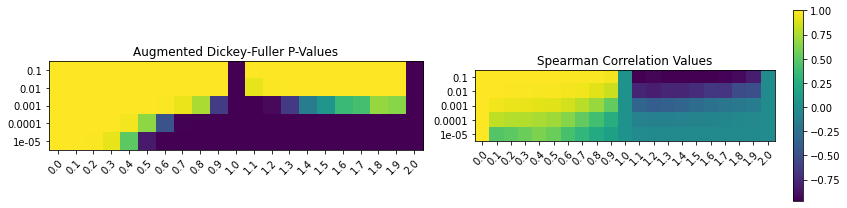

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2,figsize = (12,3))
im = ax[0].imshow(adf_results)
im = ax[1].imshow(corr_results)

for i in range(2):
  # We want to show all ticks...
  ax[i].set_xticks(np.arange(len(ds)))
  ax[i].set_yticks(np.arange(len(thresholds)))
  # ... and label them with the respective list entries
  ax[i].set_xticklabels(ds)
  ax[i].set_yticklabels(thresholds)

  # Rotate the tick labels and set their alignment.
  plt.setp(ax[i].get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

ax[0].set_title("Augmented Dickey-Fuller P-Values")
ax[1].set_title("Spearman Correlation Values")

fig.colorbar(im)

fig.tight_layout()
plt.show()

This gives us a rough idea of where to start with this particular method - although do note since it is *derivate* it scales with volatility which in turn scales with the average volume on a given asset on any day.

It is also worth noting that, fractional calculus and its numerical realizations is a very broad and diverse topic - *Lopez de Prado* has provided us with a single insight into a rich world.

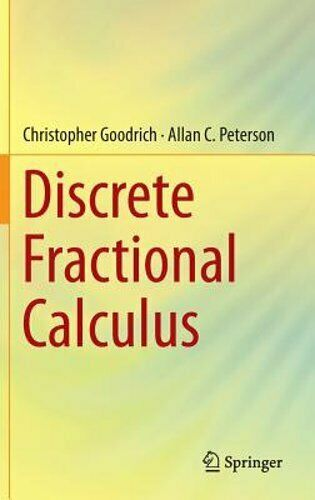

In [ ]:
# The future...?

import requests
import IPython.display as Disp
url = 'https://i.ebayimg.com/images/g/ZI0AAOSwUOJeVQPu/s-l1600.jpg'
Disp.Image(requests.get(url).content)

## Alternative Field Order Derivatives

The above generalization can be pretty harmlessly extended to other number systems that are constructed from integers.

A simple example would be with the complex numbers which exhibit interesting properties, we note that complex order derivative weights take significantly longer to converge (so we use a smaller threshold) and also will not converge if the real part is negative.

Testing for... : 2.0 + 2.0 j
Done!
Plotting...


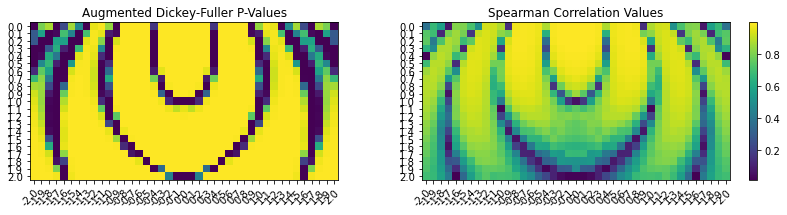

In [ ]:
from IPython.display import clear_output

reals = [i/10 for i in range(21)]
imags = [i/10 for i in range(-20,21)]

adf_results = np.zeros((len(reals),len(imags)))
corr_results = np.zeros((len(reals),len(imags)))

for idx,r in enumerate(reals):
  for idy,i in enumerate(imags):
    complex_weights = getWeightsThreshold(r+i*(0+1j),1e-2)
    out = apply_fracdiff(stock,complex_weights)

    adf_results[idx,idy] = adfuller(out.real)[1]
    corr_results[idx,idy] = spearmanr(out.real,stock[len(stock)-len(out):])[0]

    clear_output(wait=True)
    print("Testing for... :",r,"+",i,"j")

# Take absolute correlation, as this is what really matters
corr_results = np.abs(corr_results)

print("Done!")

print("Plotting...")

fig, ax = plt.subplots(1,2,figsize = (12,3))
im = ax[0].imshow(adf_results)
im = ax[1].imshow(corr_results)

for i in range(2):
  # We want to show all ticks...
  ax[i].set_yticks(np.arange(len(reals)))
  ax[i].set_xticks(np.arange(len(imags)))
  # ... and label them with the respective list entries
  ax[i].set_yticklabels(reals)
  ax[i].set_xticklabels(imags)

  # Rotate the tick labels and set their alignment.
  plt.setp(ax[i].get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

ax[0].set_title("Augmented Dickey-Fuller P-Values")
ax[1].set_title("Spearman Correlation Values")

fig.colorbar(im)

fig.tight_layout()
plt.show()

Other extensions that could be examined are hypercomplex numbers which carry the basic idea on ad infinitum. This would be significantly more complicated to handle and so has been left unless people wish to pursue this further.